# Earth2MIP Demo - Custom Datasets

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import xarray as xr
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference, run_inference, get_initializer
import matplotlib.pyplot as plt
from bayesevt._src.data.ics import LocalDataSourceXArray
from earth2mip.schema import EnsembleRun
import json
import torch
import seaborn as sns
import cartopy.crs as ccrs
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

First, we need to select a model.
This will depend on what you choose to install. 
I personally chose the `FourCastNet` model because it is the most flexible in terms of resolution (in theory). 
But in principal, we could choose other models but it would depend on the variables.

In [2]:
model_name = "fcnv2_sm" 

In [3]:
from bayesevt._src.models.earth2mip import EARTH2MIP_MODEL_VARIABLES

channel_names = EARTH2MIP_MODEL_VARIABLES["fcnv2_sm"]

***

## Initial Condition

We need to do an initial condition to propagate the data forward.
We will use a special `dataclass` which defines all of the parameters we need to load data from an `xarray.Dataset`.
This should include `.netcdf`, `.grib`, and `.grib`. 
As long as we can define the xarray engine and it follows some standards, we should be able to load it.

**Parameters**

* `t0` - `datetime` object with a time period.
* `num_steps` - the number of time steps (6h intervals)

In [4]:
# local dataset
save_name = "reanalysis_20180715_20180830_ics_v2"

file_paths = [
    f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc"
]

In [5]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="level", 
    name_convention="era5_name",
    engine="netcdf4", 
    
)

## Inference Loop Config

In [11]:
ensemble_members: int = 30

noise_amplitiude: int = 0.05

simulation_length: int = 4 * 10 # (6hrs x 4) days x 10

t0 = "2018-07-31 00:00:00"
t0_save_name = t0.split(" ")[0].replace("-","")

output_path = f"/pool/proyectos/CLINT/sa4attrs/data/pred/earth2mip/{model_name}_{t0_save_name}_ens{ensemble_members}"
output_path

group = "global"

#### Opening File

It's not straightforward to open the file because they use a nested saving pattern.
We need to manually add the `group` option when we load the data.

In [12]:
from bayesevt._src.data.netcdf import load_ensemble_dataset

In [13]:
domain = "global"
output_path_name = Path(output_path).joinpath("ensemble_out_0.nc")

ds = load_ensemble_dataset(output_path_name, domain=domain)

## Statistics

In [14]:
def where_slice(ds: xr.Dataset, variable: str, min_val: float, max_val: float, drop=True) -> xr.Dataset:

    ds = ds.where(
        (ds[variable] >= float(min_val)) & (ds[variable] <= float(max_val)),
        drop=drop
    )
        
    return ds

def post_process_temperature(ds, statistic: str=None):
    ds = ds.copy()
    # convert K to Degrees C
    ds = ds - 272.15
    if statistic == "mean":
        ds = ds.mean("ensemble")
    elif statistic == "std":
        ds = ds.std("ensemble")
    # only select event
    ds = ds.sel(time=slice("2018-07-31","2018-08-11"))
    # rename coordinates
    try:
        ds = ds.rename({"lat": "latitude", "lon": "longitude"})
    except ValueError:
        pass
    # calculate 1D frequency
    ds = ds.resample(time="1D").mean()
    # convert longitude coordinates
    ds["longitude"] =  (ds.longitude + 180) % 360 - 180
    # sort coordinates
    ds = ds.sortby("longitude").sortby("latitude")
    # select spain region
    ds = where_slice(ds, "longitude", min_val=-10, max_val=5)
    ds = where_slice(ds, "latitude", min_val=35, max_val=45)
    return ds

In [15]:
ds_mean = post_process_temperature(ds.t2m, "mean")
ds_std = post_process_temperature(ds.t2m, "std")

In [16]:
ds_true = xr.open_mfdataset(file_paths, engine="netcdf4")
ds_true = post_process_temperature(ds_true["2m_temperature"])

In [17]:
ds_true

<xarray.DataArray '2m_temperature' (time: 11, latitude: 41, longitude: 61)> Size: 110kB
dask.array<where, shape=(11, 41, 61), dtype=float32, chunksize=(1, 41, 61), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * time       (time) datetime64[ns] 88B 2018-07-31 2018-08-01 ... 2018-08-10
  * longitude  (longitude) float32 244B -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0

## Visualization

In [18]:
def plot_temperature_facet(ds, label: str="Temperature", vmin=None, vmax=None, cmap: str="RdBu_r"):
    fig = ds.plot.pcolormesh(
        col="time", col_wrap=4, cmap=cmap,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        subplot_kws={
            "projection": ccrs.PlateCarree(),
            "xlim":[ds.longitude.values.min(), ds.longitude.values.max()],
            "ylim": [ds.latitude.values.min(), ds.latitude.values.max()],
        },
        # usual xarray stuff
        cbar_kwargs={
            "orientation": "horizontal", 
            # "shrink": 0.8, "aspect": 40, 
            "fraction": 0.027, "pad": 0.045, "aspect": 40,
        },
        robust=False,
    )
    fig.map(lambda: plt.gca().coastlines())
    fig.cbar.set_label(label=f'{label} [°C]', size=20, weight='bold')
    # plt.tight_layout()
    plt.show()

    return fig

In [23]:
vmin, vmax = ds_true.min().values, ds_true.max().values
vmin -= - 0.02 * vmin
vmax += 0.02 * vmax

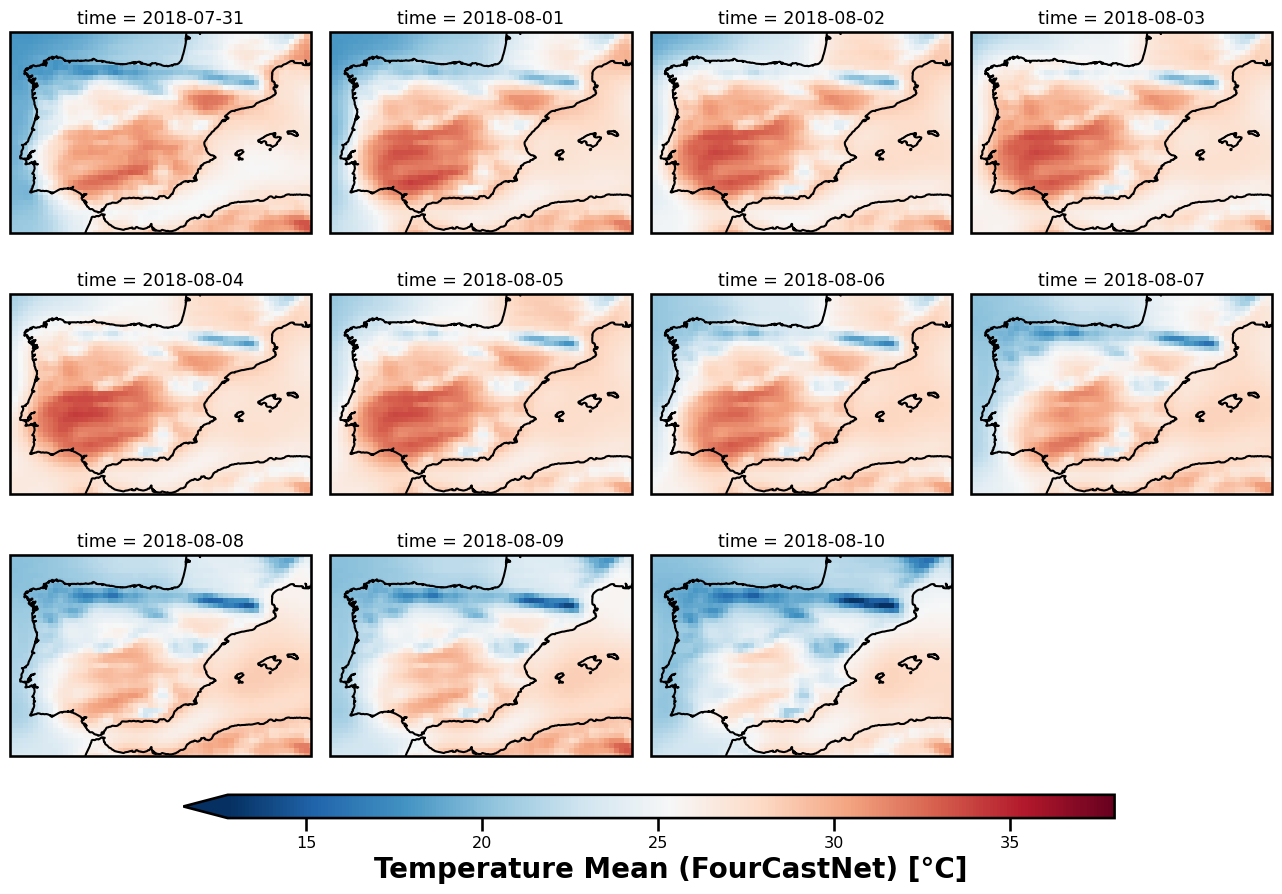

In [24]:
fig = plot_temperature_facet(ds_mean, "Temperature Mean (FourCastNet)", vmin=vmin, vmax=vmax)

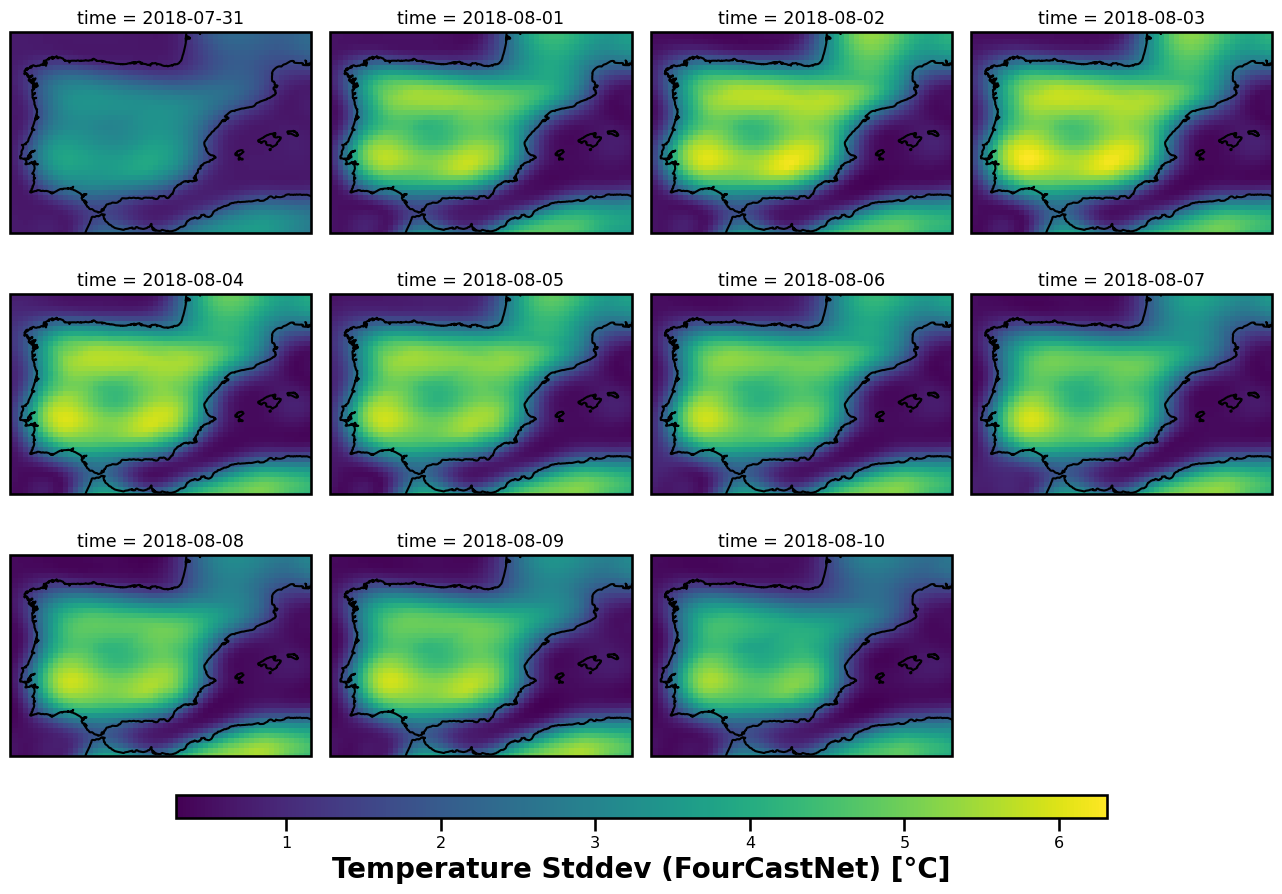

In [25]:
fig = plot_temperature_facet(ds_std, "Temperature Stddev (FourCastNet)", cmap="viridis")

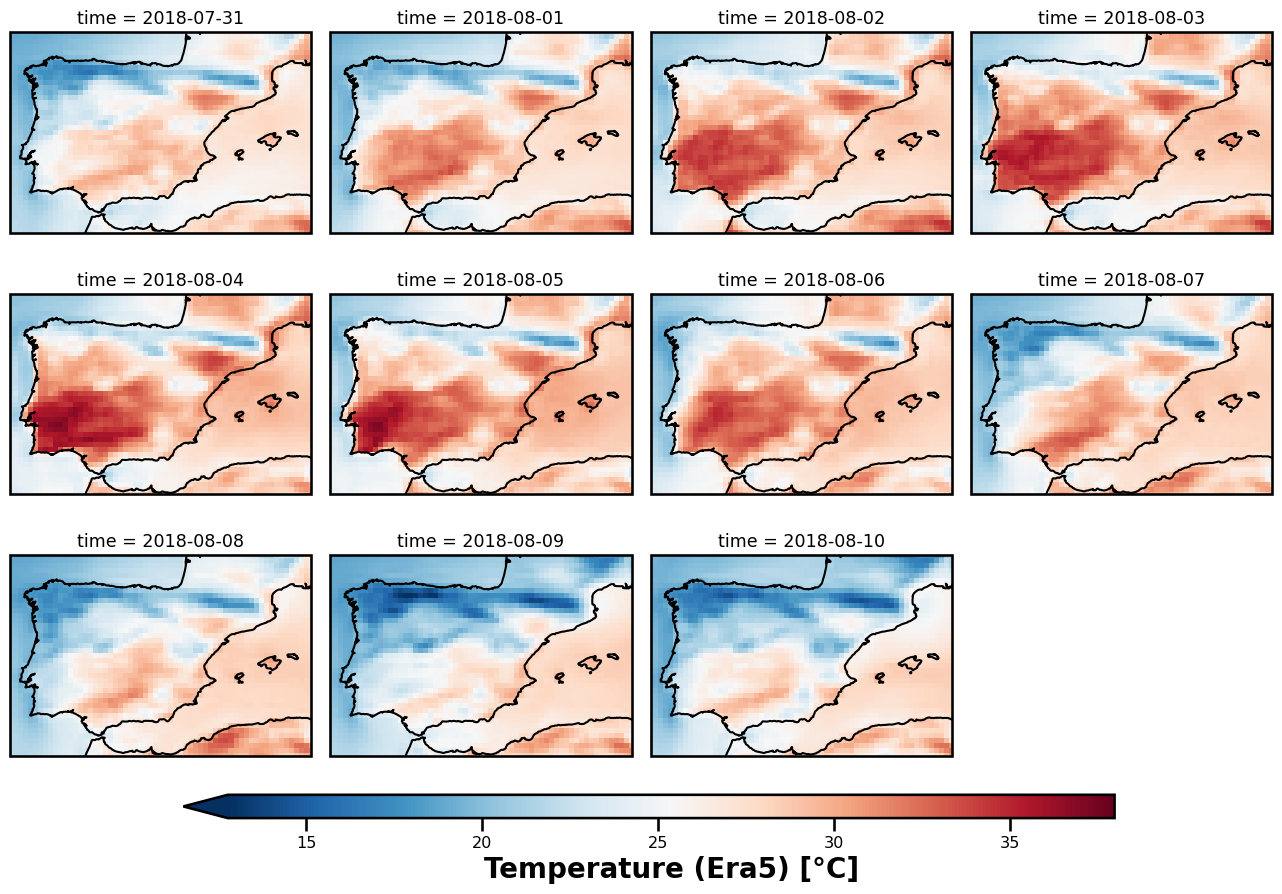

In [26]:
fig = plot_temperature_facet(ds_true, "Temperature (Era5)", vmin=vmin, vmax=vmax)

## Temporal Statistics

In [27]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask

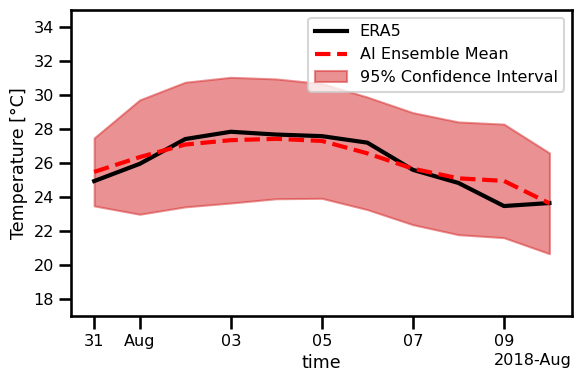

In [28]:
ds_mean_ts = ds_mean.mean(dim=["latitude", "longitude"])
ds_stddev_ts = ds_std.std(dim=["latitude", "longitude"])
ds_true_ts = ds_true.mean(dim=["latitude", "longitude"])

# plot
fig, ax = plt.subplots(figsize=(6,4))

ds_true_ts.plot(ax=ax, label="ERA5", linestyle="-", linewidth=3, color="black")
ds_mean_ts.plot(ax=ax, label="AI Ensemble Mean", linestyle="--", linewidth=3, color="red")

# error bars
ax.fill_between(
    ds_mean_ts.time,
    ds_mean_ts.values + 1.96 * ds_stddev_ts.values,
    ds_mean_ts.values - 1.96 * ds_stddev_ts.values,
    alpha=0.5,
    color="tab:red",
    label="95% Confidence Interval",
)
ax.set(
    ylim=[17, 35],
    ylabel="Temperature [°C]"
)


plt.tight_layout()
plt.legend()
plt.show()